**Import**

In [11]:
# Import libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.preprocessing import MinMaxScaler
from sklearn.base import clone, BaseEstimator, ClassifierMixin
from sklearn.model_selection import train_test_split
from sklearn.utils.validation import check_X_y
from sklearn import metrics
import random
from sklearn.model_selection import GridSearchCV

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

from sklearn.multioutput import ClassifierChain

**Informacje o zestawach danych**
Dane pochodzą z KEEL. Format został zmieniony na CSV, pliki zostały umieszczone na github w publicznym repozytorium: https://github.com/pczernec/ZUM-Mult-class.git
Zostały wykorzystane 4 zbiory danych. W celu skrócenia obliczeń na etapie eksperymentów, można opgraniczyć się do wybranych przez siebie zbiorów poprzez zakomentowanie/odkomentowanie linijek, w których dodawane są informacje o danym zbiorze, rozpoczynających się od "datasets_info.append..."

In [12]:
#0. yeast
#1. Scene
#2. Emotions

class DatasetInfo():
    def __init__(self, name, feat_num, class_num, url):
        self.name = name
        self.feat_num = feat_num
        self.class_num = class_num
        self.url = url

datasets_info = []

# Yeast
# Description:
#   This database contains information about a set of Yeast cells.
#   The task is to determine the localization site of each cell.
# Features: 103
# Instances: 2417
# Classes: 14
datasets_info.append(DatasetInfo('yeast',103,14,'https://raw.githubusercontent.com/pczernec/ZUM-MultiClass/main/data/yeast.csv'))

# Scene
# Description:
#   Scenes data set contains characteristics about images and thier classes. One image can belong to one or more classes.
# Features: 294
# Instances: 2407
# Classes: 6
datasets_info.append(DatasetInfo('Scene',294,6,'https://raw.githubusercontent.com/pczernec/ZUM-MultiClass/main/data/scene.csv'))

# Emotions
# Description:
#   Emotions from music data set contains 72 music features for 593 songs categorized into one or more out of 6 classes of emotions.
# Features: 72
# Instances:
#   593
# Classes: 6
datasets_info.append(DatasetInfo('Emotions',72,6,'https://raw.githubusercontent.com/pczernec/ZUM-MultiClass/main/data/emotions.csv'))

**Binary relevance classifier**

In [13]:
class BinaryRelevance(BaseEstimator, ClassifierMixin):
    def __init__(self, base_cl):
        self.base_cl = base_cl
        self.classifiers_models = []
        self.labels = None

    def fit(self, X, y):
        self.labels = list(y.columns)

        for label in self.labels:
            x_c, y_c = check_X_y(X, y[label])
            base_model = clone(self.base_cl)
            base_model = base_model.fit(x_c, y_c)
            self.classifiers_models.append(base_model)

    # Prediction function
    def predict(self, X):
        # List containing predictions for each label
        predictions = []

        for base_model, label in zip(self.classifiers_models, self.labels):
            prediction = base_model.predict(X)
            predictions.append(pd.DataFrame({label: prediction}))
        
        predictions = pd.concat(predictions, axis=1)

        return predictions.to_numpy()

**Classifier Chains classifier**

In [14]:
class ClassifierChains(BaseEstimator, ClassifierMixin):
    def __init__(self, base_cl, order=None):
        self.base_cl=base_cl
        self.classifiers_models = []
        self.order = order
        self.labels = None
        self.labelsOrigin = None

    def fit(self, X, y):
        if self.order is None:
            self.order = list(range(y.shape[1]))

        self.labels = [list(y.columns)[i] for i in self.order]

        self.labelsOrigin = list(y.columns)

        Xy_joined = X.copy()

        for i, label in enumerate(self.labels):
            base_model = clone(self.base_cl)
            x_c, y_c = check_X_y(Xy_joined, y[label])
            base_model.fit(x_c, y_c)
            self.classifiers_models.append(base_model)
            Xy_joined = pd.concat([Xy_joined, y[label]], axis=1)

    def predict(self, X):
        predictions = []

        Xy_joined = X.copy()
        Xy_joined.reset_index(drop=True, inplace=True)

        for label, base_model in zip(self.labels, self.classifiers_models):
            prediction = base_model.predict(Xy_joined.values)
            predictions.append(pd.DataFrame({label: prediction}))
            Xy_joined.columns = Xy_joined.columns.astype(str)
            Xy_joined = pd.concat([Xy_joined, pd.DataFrame({label: prediction})], axis=1)

        predictions = pd.concat(predictions, axis=1)

        predictions = predictions[self.labelsOrigin]
        return predictions.to_numpy()

Eksperymenty

In [15]:
base_classifiers = [KNeighborsClassifier(),DecisionTreeClassifier(),RidgeClassifier(),SVC(),GaussianNB()]
base_classifiers_name = ["KNN","Decision Tree", "Ridge", "SVM", "GaussianNB"]

scores = pd.DataFrame(columns = ["dataset", "algorithm", "base_classifier", "accuracy", "hamming_loss", "recall", "precision", "f1"])

for dataset in datasets_info:
    print(dataset.name)
    df = pd.read_csv(dataset.url)
    X = df.iloc[:, :dataset.feat_num]
    y = df.iloc[:, dataset.feat_num:]
    #Normalizacja
    scaler = MinMaxScaler()
    scaler.fit(X)
    X = pd.DataFrame(scaler.transform(X))
    #Podzial na zbiory uczacy i testowy
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

    for base_classifier,base_classifier_name in zip(base_classifiers,base_classifiers_name):
        #Binary relevance
        BRcl = BinaryRelevance(base_classifier)
        BRcl.fit(X_train, y_train)
        y_predict = BRcl.predict(X_test)
        new_row = {'dataset':dataset.name, 'algorithm':'BR', 'base_classifier':base_classifier_name, 'accuracy':metrics.accuracy_score(y_test, y_predict), 'hamming_loss':metrics.hamming_loss(y_test, y_predict),  'recall':metrics.recall_score(y_test, y_predict, average='weighted'), 'precision':metrics.precision_score(y_test, y_predict, average='weighted',labels=np.unique(y_predict)), 'f1':metrics.f1_score(y_test, y_predict, average='weighted',labels=np.unique(y_predict))}
        scores = pd.concat([scores, pd.DataFrame([new_row])], ignore_index=True)

        #Classifier chains natural order
        cc = ClassifierChains(base_classifier)
        cc.fit(X_train, y_train)
        y_predict = cc.predict(X_test)
        new_row = {'dataset':dataset.name, 'algorithm':'CC', 'base_classifier':base_classifier_name, 'accuracy':metrics.accuracy_score(y_test, y_predict), 'hamming_loss':metrics.hamming_loss(y_test, y_predict),  'recall':metrics.recall_score(y_test, y_predict, average='weighted'), 'precision':metrics.precision_score(y_test, y_predict, average='weighted',labels=np.unique(y_predict)), 'f1':metrics.f1_score(y_test, y_predict, average='weighted',labels=np.unique(y_predict))}
        scores = pd.concat([scores, pd.DataFrame([new_row])], ignore_index=True)

        #Classifier chains ScikitLearn natural order
        cc_scikit = ClassifierChain(base_classifier)
        cc_scikit.fit(X_train, y_train)
        y_predict = cc_scikit.predict(X_test)
        new_row = {'dataset':dataset.name, 'algorithm':'CC_scikit', 'base_classifier':base_classifier_name, 'accuracy':metrics.accuracy_score(y_test, y_predict), 'hamming_loss':metrics.hamming_loss(y_test, y_predict),  'recall':metrics.recall_score(y_test, y_predict, average='weighted'), 'precision':metrics.precision_score(y_test, y_predict, average='weighted',labels=np.unique(y_predict)), 'f1':metrics.f1_score(y_test, y_predict, average='weighted',labels=np.unique(y_predict))}
        scores = pd.concat([scores, pd.DataFrame([new_row])], ignore_index=True)

        #Classifier chains with order grid search
        orders_rand = [list(range(0, y_test.shape[1])) for i in list(range(1, 10))]
        for order in orders_rand:
            random.shuffle(order)
        param_grid ={'order': orders_rand}
        cc_gs= GridSearchCV(ClassifierChains(base_classifier), param_grid, scoring="accuracy") #deafult 5-fold cv
        cc_gs.fit(X_train, y_train)
        y_predict = cc_gs.predict(X_test)
        new_row = {'dataset':dataset.name, 'algorithm':'CC grid search', 'base_classifier':base_classifier_name, 'accuracy':metrics.accuracy_score(y_test, y_predict), 'hamming_loss':metrics.hamming_loss(y_test, y_predict),  'recall':metrics.recall_score(y_test, y_predict, average='weighted'), 'precision':metrics.precision_score(y_test, y_predict, average='weighted',labels=np.unique(y_predict)), 'f1':metrics.f1_score(y_test, y_predict, average='weighted',labels=np.unique(y_predict))}
        scores = pd.concat([scores, pd.DataFrame([new_row])], ignore_index=True)


yeast
Scene
Emotions


**Wyniki**

In [16]:
print(scores)

scores.to_csv('out.csv')

     dataset       algorithm base_classifier  accuracy  hamming_loss   
0      yeast              BR             KNN  0.212810      0.203365  \
1      yeast              CC             KNN  0.239669      0.210153   
2      yeast       CC_scikit             KNN  0.239669      0.210153   
3      yeast  CC grid search             KNN  0.252066      0.211482   
4      yeast              BR   Decision Tree  0.041322      0.268743   
5      yeast              CC   Decision Tree  0.097107      0.288961   
6      yeast       CC_scikit   Decision Tree  0.109504      0.275679   
7      yeast  CC grid search   Decision Tree  0.090909      0.291765   
8      yeast              BR           Ridge  0.154959      0.197609   
9      yeast              CC           Ridge  0.177686      0.216204   
10     yeast       CC_scikit           Ridge  0.177686      0.216204   
11     yeast  CC grid search           Ridge  0.210744      0.205431   
12     yeast              BR             SVM  0.188017      0.18

In [17]:
scores_list = scores.to_numpy()

Wykresy yeast

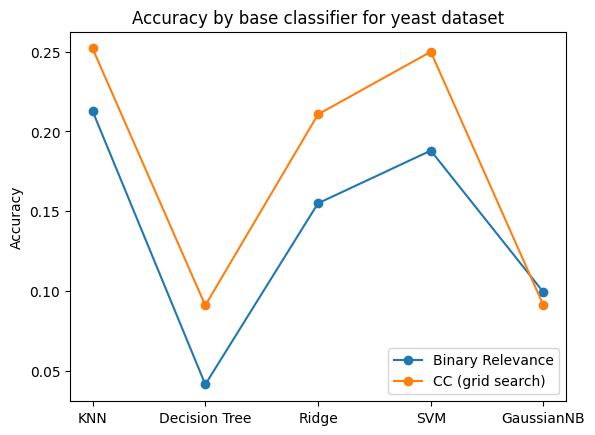

In [18]:
plt.ylabel('Accuracy')
plt.title('Accuracy by base classifier for yeast dataset')
plt.plot(list(scores_list[[0,4,8,12,16],2]),list(scores_list[[0,4,8,12,16],3]),marker='o',)
plt.plot(list(scores_list[[3,7,11,15,19],2]),list(scores_list[[3,7,11,15,19],3]),marker='o',)
plt.legend(['Binary Relevance','CC (grid search)'])

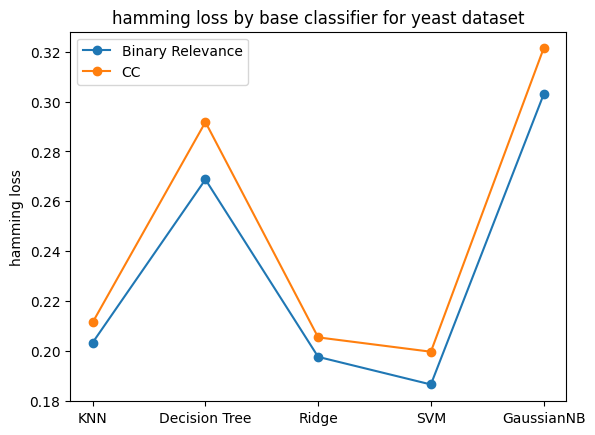

In [19]:
plt.ylabel('hamming loss')
plt.title('hamming loss by base classifier for yeast dataset')
plt.plot(list(scores_list[[0,4,8,12,16],2]),list(scores_list[[0,4,8,12,16],4]),marker='o',)
plt.plot(list(scores_list[[3,7,11,15,19],2]),list(scores_list[[3,7,11,15,19],4]),marker='o',)
plt.legend(['Binary Relevance','CC'])

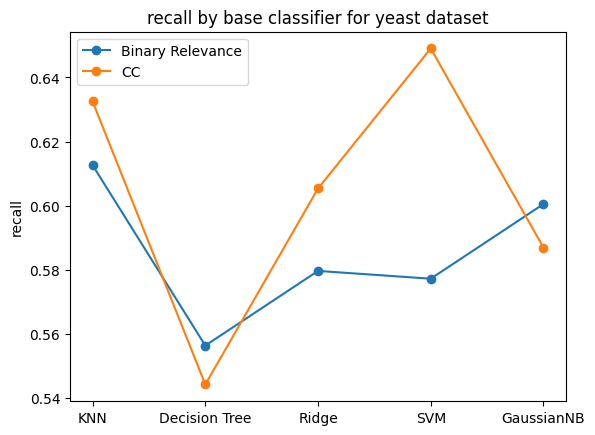

In [20]:
plt.ylabel('recall')
plt.title('recall by base classifier for yeast dataset')
plt.plot(list(scores_list[[0,4,8,12,16],2]),list(scores_list[[0,4,8,12,16],5]),marker='o',)
plt.plot(list(scores_list[[3,7,11,15,19],2]),list(scores_list[[3,7,11,15,19],5]),marker='o',)
plt.legend(['Binary Relevance','CC'])

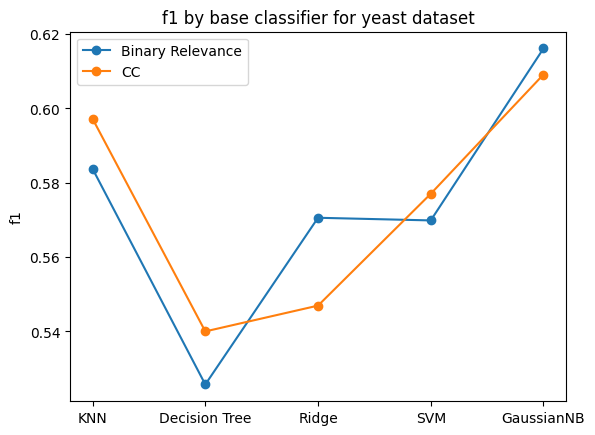

In [21]:
plt.ylabel('f1')
plt.title('f1 by base classifier for yeast dataset')
plt.plot(list(scores_list[[0,4,8,12,16],2]),list(scores_list[[0,4,8,12,16],7]),marker='o',)
plt.plot(list(scores_list[[3,7,11,15,19],2]),list(scores_list[[3,7,11,15,19],7]),marker='o',)
plt.legend(['Binary Relevance','CC'])

Wykresy Scene

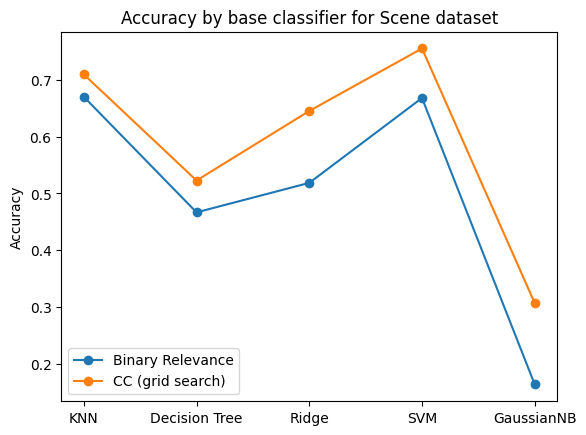

In [22]:
plt.ylabel('Accuracy')
plt.title('Accuracy by base classifier for Scene dataset')
plt.plot(list(scores_list[[20,24,28,32,36],2]),list(scores_list[[20,24,28,32,36],3]),marker='o',)
plt.plot(list(scores_list[[23,27,31,35,39],2]),list(scores_list[[23,27,31,35,39],3]),marker='o',)
plt.legend(['Binary Relevance','CC (grid search)'])

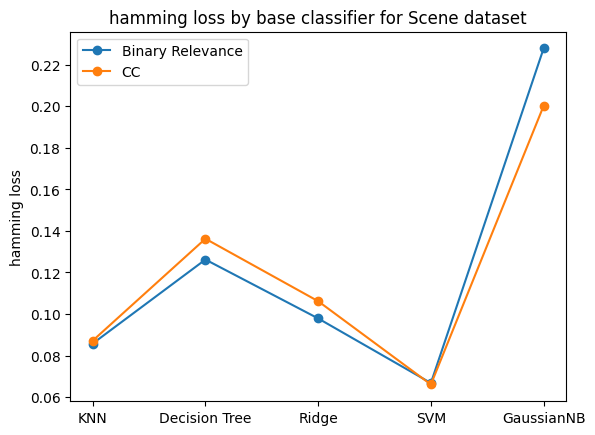

In [23]:
plt.ylabel('hamming loss')
plt.title('hamming loss by base classifier for Scene dataset')
plt.plot(list(scores_list[[20,24,28,32,36],2]),list(scores_list[[20,24,28,32,36],4]),marker='o',)
plt.plot(list(scores_list[[23,27,31,35,39],2]),list(scores_list[[23,27,31,35,39],4]),marker='o',)
plt.legend(['Binary Relevance','CC'])

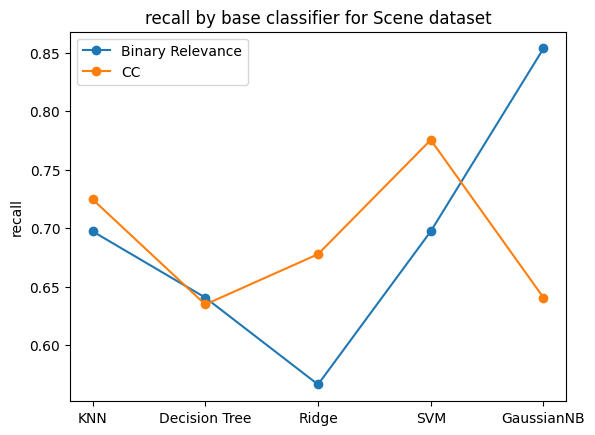

In [24]:
plt.ylabel('recall')
plt.title('recall by base classifier for Scene dataset')
plt.plot(list(scores_list[[20,24,28,32,36],2]),list(scores_list[[20,24,28,32,36],5]),marker='o',)
plt.plot(list(scores_list[[23,27,31,35,39],2]),list(scores_list[[23,27,31,35,39],5]),marker='o',)
plt.legend(['Binary Relevance','CC'])

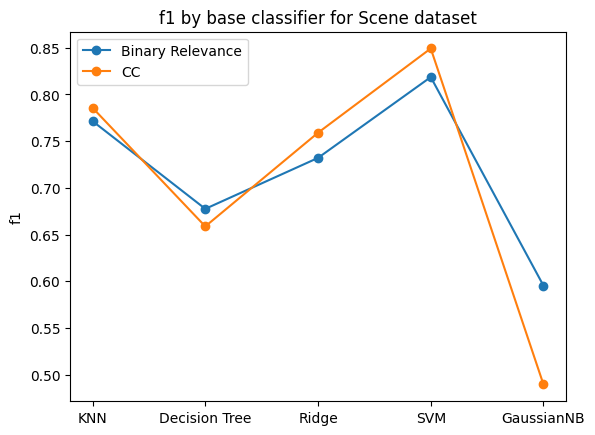

In [25]:
plt.ylabel('f1')
plt.title('f1 by base classifier for Scene dataset')
plt.plot(list(scores_list[[20,24,28,32,36],2]),list(scores_list[[20,24,28,32,36],7]),marker='o',)
plt.plot(list(scores_list[[23,27,31,35,39],2]),list(scores_list[[23,27,31,35,39],7]),marker='o',)
plt.legend(['Binary Relevance','CC'])

Wykresy Emotions

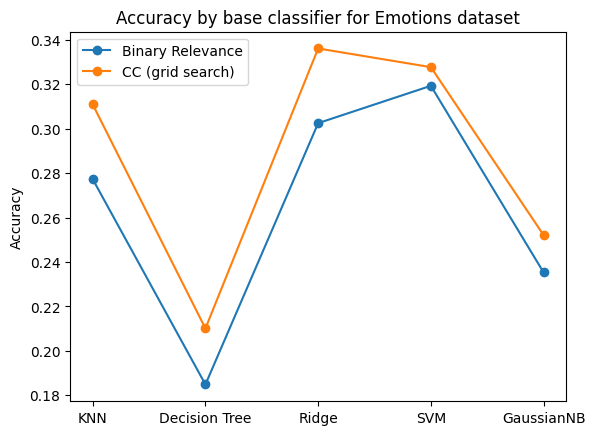

In [26]:
plt.ylabel('Accuracy')
plt.title('Accuracy by base classifier for Emotions dataset')
plt.plot(list(scores_list[[40,44,48,52,56],2]),list(scores_list[[40,44,48,52,56],3]),marker='o',)
plt.plot(list(scores_list[[43,47,51,55,59],2]),list(scores_list[[43,47,51,55,59],3]),marker='o',)
plt.legend(['Binary Relevance','CC (grid search)'])

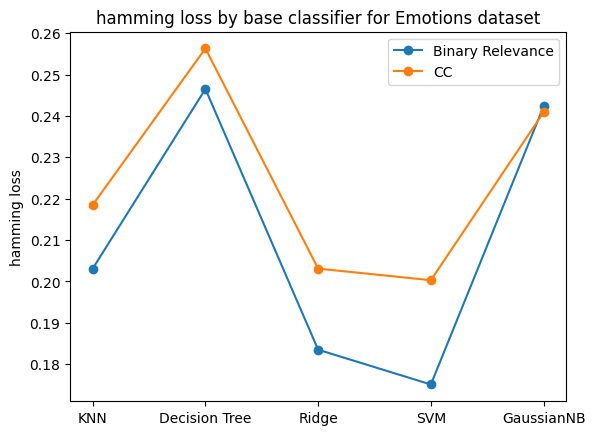

In [27]:
plt.ylabel('hamming loss')
plt.title('hamming loss by base classifier for Emotions dataset')
plt.plot(list(scores_list[[40,44,48,52,56],2]),list(scores_list[[40,44,48,52,56],4]),marker='o',)
plt.plot(list(scores_list[[43,47,51,55,59],2]),list(scores_list[[43,47,51,55,59],4]),marker='o',)
plt.legend(['Binary Relevance','CC'])

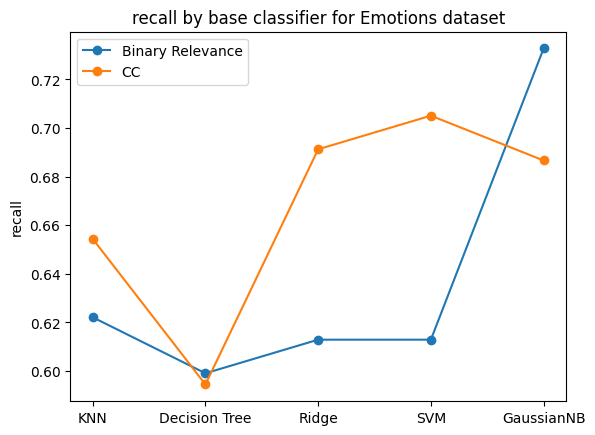

In [28]:
plt.ylabel('recall')
plt.title('recall by base classifier for Emotions dataset')
plt.plot(list(scores_list[[40,44,48,52,56],2]),list(scores_list[[40,44,48,52,56],5]),marker='o',)
plt.plot(list(scores_list[[43,47,51,55,59],2]),list(scores_list[[43,47,51,55,59],5]),marker='o',)
plt.legend(['Binary Relevance','CC'])

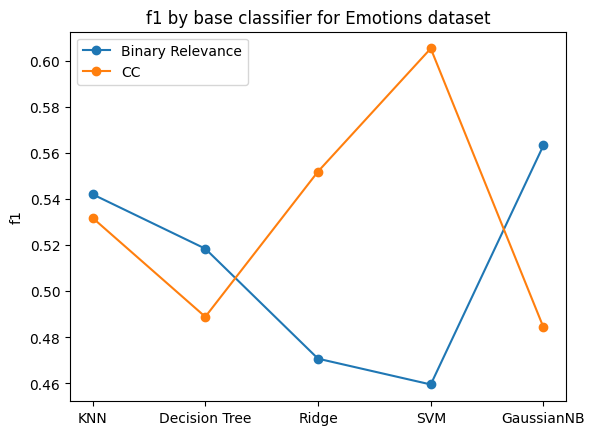

In [29]:
plt.ylabel('f1')
plt.title('f1 by base classifier for Emotions dataset')
plt.plot(list(scores_list[[40,44,48,52,56],2]),list(scores_list[[40,44,48,52,56],7]),marker='o',)
plt.plot(list(scores_list[[43,47,51,55,59],2]),list(scores_list[[43,47,51,55,59],7]),marker='o',)
plt.legend(['Binary Relevance','CC'])

Wnioski



Źródła
1. Jesse Read, Bernhard Pfahringer, Geoffrey Holmes, and Eibe Frank. Classifier Chains: A Review and Perspectives. Journal of Artificial Intelligence Research, 70:683–718, 2021.
2. Jesse Read, Bernhard Pfahringer, Geoff Holmes, and Eibe Frank. Classifier chains
for multi-label classification. Machine Learning, 85(3):333–359, 2011.